# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

In [47]:
%load_ext autoreload
%autoreload 2

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]
y = y.astype(int)

Давайте посмотрим на какое-нибудь изображение из наших данных:

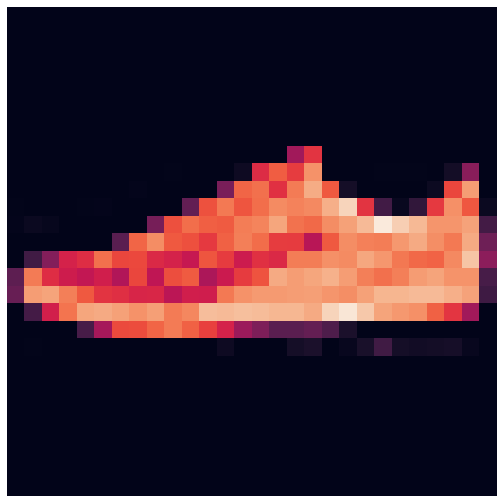

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

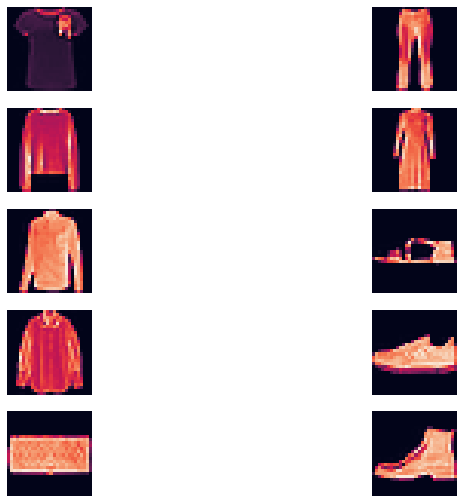

In [6]:
for clas in range(10):
    position= np.where(y == clas)[0][0]
    image = X[position].reshape(28, 28, 1)
    plt.subplot(5,2,clas+1)
    plt.imshow(image)
    plt.axis("off")

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов.

In [7]:
y_pd_series = pd.Series(y)
classes = pd.DataFrame({'amount of elements in class':y_pd_series.value_counts(),
                        'class':y_pd_series.value_counts().index}).set_index('class')
print(classes)
classes.describe()

       amount of elements in class
class                             
3                              121
8                              109
9                              106
1                              102
6                              101
5                               98
4                               96
2                               95
0                               93
7                               79


,amount of elements in class
count,10.000000
mean,100.000000
std,11.045361
min,79.000000
25%,95.250000
50%,99.500000
75%,105.000000
max,121.000000


### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [9]:
binary_train_X = X_train[np.where((y_train==0) | (y_train==1))]
binary_train_y = y_train[np.where((y_train==0) | (y_train==1))]
binary_test_X = X_test[np.where((y_test==0) | (y_test==1))]
binary_test_y = y_test[np.where((y_test==0) | (y_test==1))]

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [10]:
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [11]:
# compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [12]:
# compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [13]:
# compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [14]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

40 ms ± 90.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.67 ms ± 55.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
35.3 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [15]:
# predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)
print(prediction)

[1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1.]


### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [16]:
# binary_classification_metrics in metrics.py

In [17]:
metrics = binary_classification_metrics(prediction, binary_test_y)
metrics_table = pd.DataFrame({'Metric':['precision', 'recall', 'f1', 'accuracy'],'Values':metrics}).set_index('Metric')
metrics_table

,Values
Metric,
precision,0.958333
recall,0.958333
f1,0.958333
accuracy,0.957447


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('precision:', precision_score(binary_test_y, prediction))
print('recall:', recall_score(binary_test_y, prediction))
print('f1:', f1_score(binary_test_y, prediction))
print('accuracy:', accuracy_score(binary_test_y, prediction))

precision: 0.9583333333333334
recall: 0.9583333333333334
f1: 0.9583333333333334
accuracy: 0.9574468085106383


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [19]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = list()
    test_metrics = list()
    for i in params:
        # обучить на тренировочных
        knn_classifier = KNNClassifier(k=i)
        knn_classifier.fit(X_train, y_train)

        # предсказать на тестовых
        prediction_test = knn_classifier.predict(X_test)
        prediction_train = knn_classifier.predict(X_train)

        # метрика
        train_metrics += [metric(y_train, prediction_train)]
        test_metrics += [metric(y_test, prediction_test)]

    return train_metrics, test_metrics

In [20]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, f1_score)
print(train_metrics)
print(test_metrics)

[1.0, 1.0, 0.9936305732484078, 0.9873417721518987, 0.9871794871794872, 0.9871794871794872, 0.9506172839506173]
[1.0, 0.9787234042553191, 0.9583333333333334, 0.9583333333333334, 0.9583333333333334, 0.9583333333333334, 0.9199999999999999]


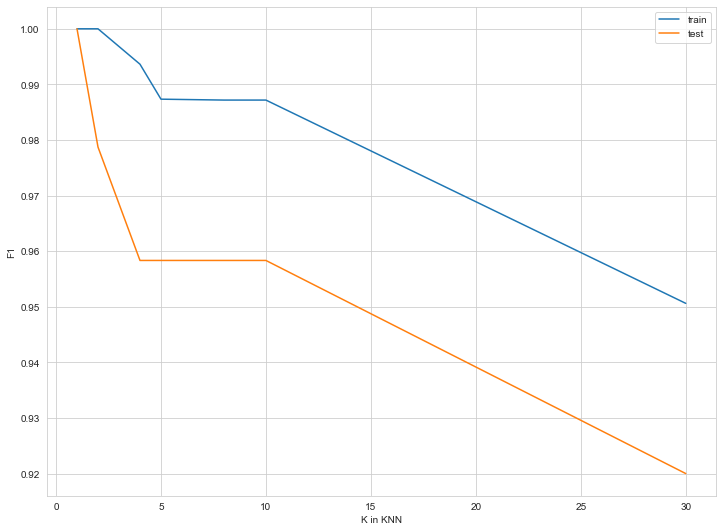

In [21]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("F1");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

In [22]:
# k = 5
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(binary_train_X, binary_train_y)
prediction = knn_classifier.predict(binary_test_X)

# metrics
metrics = binary_classification_metrics(prediction, binary_test_y)
metrics_table = pd.DataFrame({'Metric':['precision', 'recall', 'f1', 'accuracy'],'Values':metrics}).set_index('Metric')
print(metrics_table)

             Values
Metric             
precision  0.958333
recall     0.958333
f1         0.958333
accuracy   0.957447


### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [23]:
# predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
print(predictions)

[1 7 3 3 8 1 8 2 1 0 0 9 5 6 3 1 0 7 1 7 4 5 2 8 0 6 3 2 9 5 3 2 4 8 6 2 1
 8 3 6 7 7 8 2 9 3 4 6 0 8 7 2 6 9 1 7 7 3 9 0 0 4 0 2 9 2 7 6 7 2 1 7 8 1
 6 3 9 7 1 5 9 1 9 4 2 1 5 1 9 1 3 8 5 8 3 7 9 6 4 9 2 9 2 0 3 3 2 0 7 5 3
 7 6 5 5 7 5 9 5 3 0 3 5 1 3 6 9 9 7 8 1 3 8 3 4 6 2 2 6 6 4 0 0 8 9 2 9 7
 7 4 6 5 7 9 6 3 1 6 5 3 0 4 4 8 1 0 2 7 0 9 3 0 5 0 4 8 7 1 2 1 0 3 8 9 0
 6 3 0 4 8 2 3 5 4 0 3 1 0 1 5]


Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [24]:
# multiclass_accuracy in metrics.py
print('multiclass_accuracy:', multiclass_accuracy(predictions, y_test))

multiclass_accuracy: 0.795


Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [25]:
def find_best_k_multi(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = list()
    test_metrics = list()
    for i in params:
        # обучить на тренировочных
        knn_classifier = KNNClassifier(k=i)
        knn_classifier.fit(X_train, y_train)

        # предсказать на тестовых
        prediction_test = knn_classifier.predict(X_test)
        prediction_train = knn_classifier.predict(X_train)

        # метрика
        train_metrics += [multiclass_accuracy(prediction_train, y_train)]
        test_metrics += [multiclass_accuracy(prediction_test, y_test)]

    return train_metrics, test_metrics

In [26]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k_multi(X_train, y_train, X_test, y_test, params)
print(train_metrics)
print(test_metrics)

[1.0, 0.89875, 0.84125, 0.83625, 0.81625, 0.80125, 0.7425]
[0.795, 0.78, 0.785, 0.79, 0.8, 0.795, 0.745]


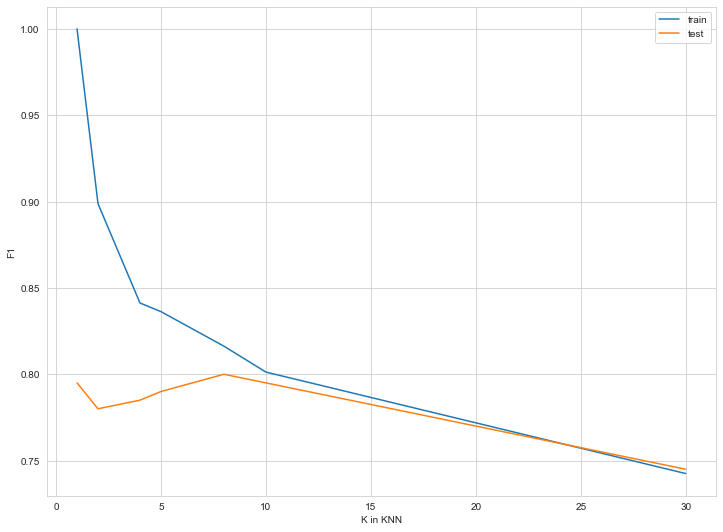

In [27]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("F1");

In [28]:
# k = 10
knn_classifier = KNNClassifier(k=7)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

print('multiclass_accuracy:', multiclass_accuracy(predictions, y_test))

multiclass_accuracy: 0.805


## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [29]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from metrics import mse, mae, r_squared

In [30]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [31]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [32]:
# eda
print(X.describe(), '\n')
print(X.dtypes)

                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -3.639623e-16  1.309912e-16 -8.013951e-16  1.289818e-16 -9.042540e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123996e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665645e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670611e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564384e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320442e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  
mean   1.301121e-16 -4.563971e-16  3.863174e-16 -3.848103e-16 -3.398488e-16  
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761

In [33]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [34]:
# standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
from sklearn.pipeline import Pipeline

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [36]:
regression_model = KNeighborsRegressor()
regression_model.fit(X_train, y_train)

KNeighborsRegressor()

In [37]:
regression_prediction = regression_model.predict(X_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [38]:
# r_squared, mse, mae in metrics.py
regression_metrix = [mse(regression_prediction, y_test), mae(regression_prediction, y_test), r_squared(regression_prediction, y_test)]
metrics_table = pd.DataFrame({'Metric':['MSE', 'MAE', 'R-squared'],'Values':regression_metrix}).set_index('Metric')
print(metrics_table)

                Values
Metric                
MSE        3770.775281
MAE          47.386517
R-squared     0.270726


Проверка реализованных метрик функциями из `sklearn`

In [39]:
regression_metrix = [mean_squared_error(regression_prediction, y_test), mean_absolute_error(regression_prediction, y_test), r2_score(y_test, regression_prediction)]
metrics_table = pd.DataFrame({'Metric':['MSE', 'MAE', 'R-squared'],'Values':regression_metrix}).set_index('Metric')
print(metrics_table)

                Values
Metric                
MSE        3770.775281
MAE          47.386517
R-squared     0.270726


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [40]:
def find_best_k(X_train, y_train, X_test, y_test, params, metrics):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    test_metrics = list()
    for i in params:
        # обучить на тренировочных
        knn_regression = KNeighborsRegressor(n_neighbors=i)
        knn_regression.fit(X_train, y_train)

        # предсказание
        prediction_test = knn_regression.predict(X_test)

        # метрика
        test_metrics += [metrics(prediction_test, y_test)]

    return test_metrics

In [41]:
params = [1, 2, 4, 5, 8, 10, 15, 30]
test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, mse)
print(test_metrics)

[6594.337078651685, 4696.126404494382, 3779.2233146067415, 3770.775280898876, 3081.779494382022, 3057.7876404494377, 3116.12, 3019.916491885144]


Text(0, 0.5, 'MSE')

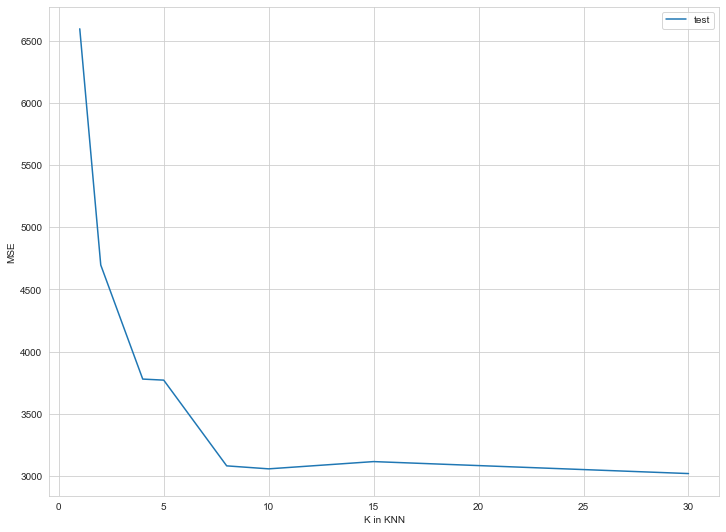

In [42]:
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("MSE")

In [43]:
params = [1, 2, 4, 5, 8, 10, 15, 30]
test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, mae)
print(test_metrics)

[61.91011235955056, 50.960674157303366, 47.28089887640449, 47.38651685393258, 44.103932584269664, 44.31910112359551, 44.28389513108614, 45.16142322097378]


Text(0, 0.5, 'MSE')

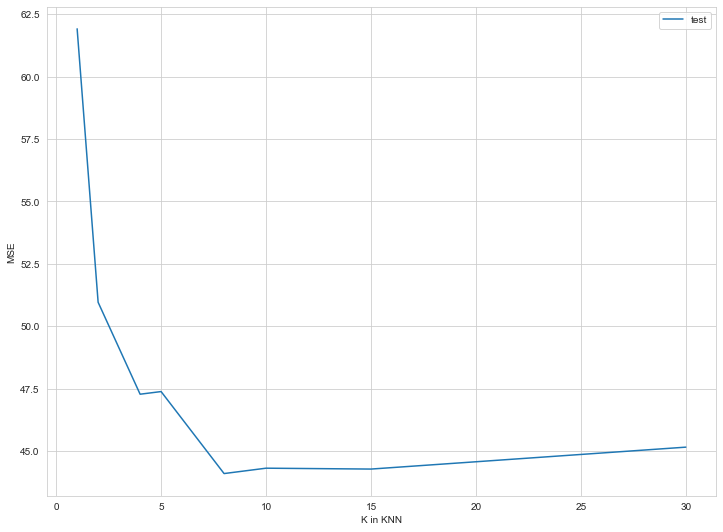

In [44]:
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("MSE")

In [45]:
params = [1, 2, 4, 5, 8, 10, 15, 30]
test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, r_squared)
print(test_metrics)

[-0.27535577385155774, 0.091761331992259, 0.26909191667472, 0.2707257804639853, 0.40397871309589317, 0.4086187776047855, 0.39733720211541035, 0.41594312081135676]


Text(0, 0.5, 'R_squared')

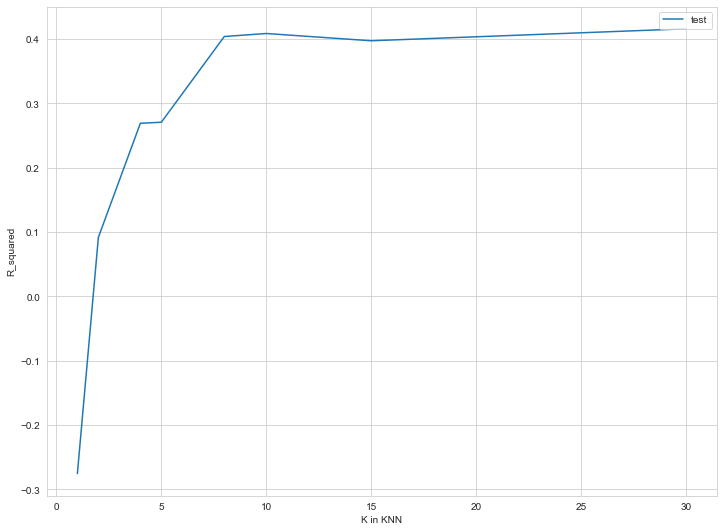

In [46]:
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("R_squared")

Оптимальное число соседей k=8

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Сначала было супер сложно, потом сильно сложно, потом просто сложно, но когда дело дошло до регрессии, все уже пошло как по маслу. Зато в конце, после долгих часов борьбы с кодом, осталось приятное чувство, что я молодец. В общем, мне даже в какой-то степени понравилось :D